In [1]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy import signal

import pickle
import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

In [2]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS


In [3]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[10, 10], N_chirps=1)

## Setting up the target

In [4]:
target_model_1 = mmars.Target(start_position=np.array([[0.001,5.001]]), start_velocity=1., T_total=100., T_frame=0.1)

target_model_1.generate_trajectory(trajectory_type="linear")

target_ground_truth = target_model_1.get_trajectory()

mrblatcomp = mmars.MRBLaT_Functions(radar_model_1, target_model_1)

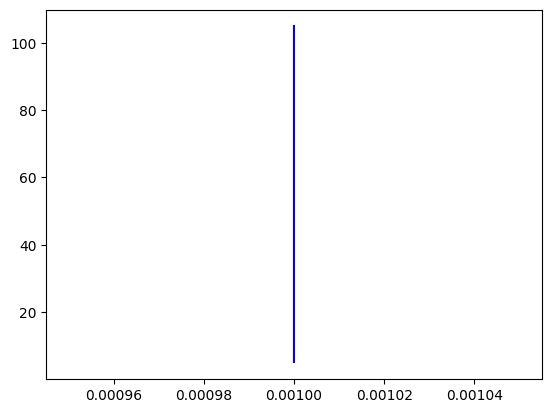

In [5]:
plt.plot(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="blue")

In [6]:
simulation_data = mmars.MRBLaT_Functions(radar_model_1, target_model_1)

simulation_data.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001CFD02DC130> and <mmars.target.Target object at 0x000001CFD02F5DC0>


100%|██████████| 1000/1000 [00:00<00:00, 1106.05it/s]


In [7]:
sim_data = simulation_data.get_data()


In [8]:
frame = 1

print(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

max_range = 100
Ns = 3072


# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

radar_model_1.generate_S_signal(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

S_N = radar_model_1.get_S_signal.flatten()[:, np.newaxis]/np.sqrt(256)

0.001 5.101


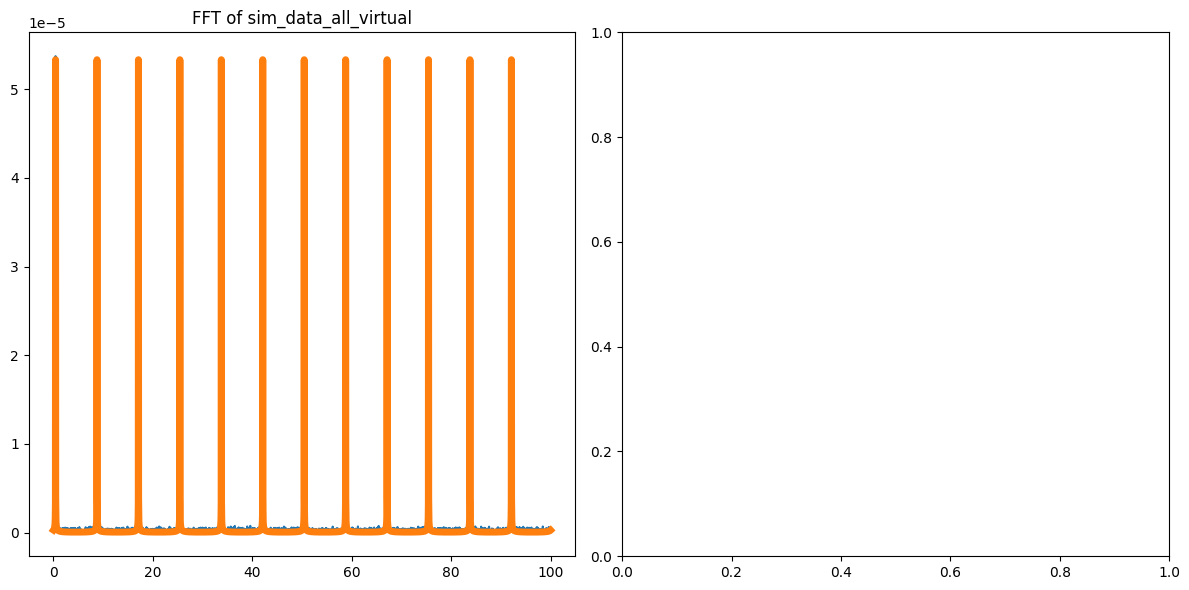

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


#axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T), lw=2)
axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier))
axs[0].plot(np.linspace(0, max_range, Ns), np.abs(S_N), lw=5)


#axs[0].set_xlim([0, 10])
#axs[0].set_xlim([0, 10])
axs[0].set_title('FFT of sim_data_all_virtual')

#axs[1].set_xlim([0, 10])
#axs[1].set_title('Generated S Signal')

plt.tight_layout()
plt.show()

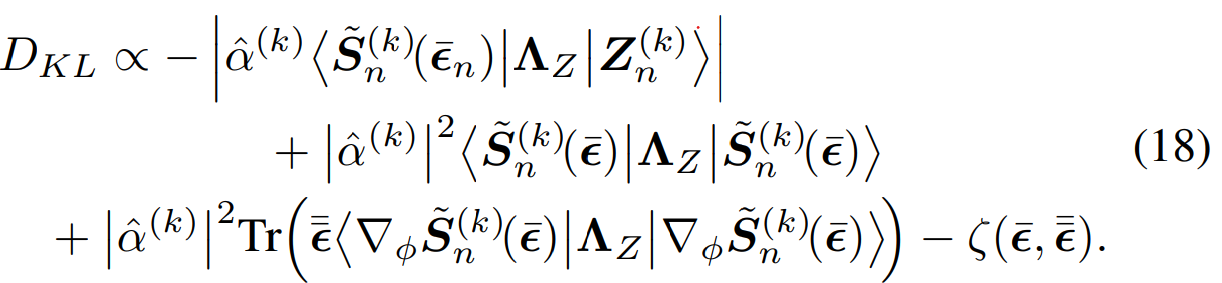

In [10]:
#Lambda_z = np.eye(3072) * (Boltzmann * 290 * 0.77e9)**(-2)
Lambda_z = np.eye(3072) * (radar_model_1.get_standardDeviation)**(-2)
Lambda_z = csr_matrix(Lambda_z)

In [11]:
sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual
data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])
data_fourier_energy = data_fourier.conj().T @ data_fourier
data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

In [12]:
last_frame_x = target_model_1.get_trajectory()[0][frame-1]
last_frame_y = target_model_1.get_trajectory()[1][frame-1]

param = (last_frame_x, last_frame_y, 1, 1)
bound = [(-100,100), (0.1,100), (0.00001, 10), (0.00001, 10)]

input = np.array([target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame], 0.5, 0.5])

result = minimize(mrblatcomp.D_KL, param, bounds = bound,  args=(data_fourier, last_frame_x, last_frame_y, (1,1,1,1), True), method='nelder-mead')
#mrblatcomp.D_KL(input, data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=True)

[[-252148.52774504]] [[362459.48633961]] [[145346.27468827]] 2.8378770664093453
[[-252103.55576485]] [[362459.48336863]] [[145346.27330286]] 2.8378770664093453
[[-101641.06061093]] [[298196.31864038]] [[117757.38720548]] 2.8378770664093453
[[-252148.52774504]] [[362459.48633961]] [[146523.48933792]] 2.8622721484940614
[[-252148.52774504]] [[362459.48633961]] [[151436.37377303]] 2.8622721484940614
[[47760.38594342]] [[445005.15690622]] [[186142.09068068]] 2.8625696789997166
[[-374822.4079259]] [[328370.40631507]] [[131454.67329049]] 2.8441076161599814
[[-371419.66902375]] [[344888.99917707]] [[132927.26856641]] 2.8277408343019648
[[-389274.60819422]] [[336503.0322585]] [[131144.52445756]] 2.810934796714386
[[-356135.16934194]] [[324396.2235314]] [[124133.5451155]] 2.783847128882602
[[-356104.81252333]] [[324396.22730752]] [[125628.6188998]] 2.822796253046353
[[-204226.78711456]] [[307238.77974981]] [[116907.0739785]] 2.815072427746643
[[-327053.04701154]] [[319996.86794196]] [[123382.04

In [20]:
print(f"{result}\n{target_ground_truth[0][frame], target_ground_truth[1][frame]}")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -1225.319602355606
             x: [ 1.011e+01  1.009e+01  7.647e-04  1.000e-05]
           nit: 137
          nfev: 240
 final_simplex: (array([[ 1.011e+01,  1.009e+01,  7.647e-04,  1.000e-05],
                       [ 1.011e+01,  1.009e+01,  7.627e-04,  1.000e-05],
                       ...,
                       [ 1.011e+01,  1.009e+01,  7.620e-04,  1.000e-05],
                       [ 1.011e+01,  1.009e+01,  7.606e-04,  1.000e-05]]), array([-1.225e+03, -1.225e+03, -1.225e+03, -1.225e+03,
                       -1.225e+03]))
(np.float64(10.100998333341666), np.float64(10.100999999999999))


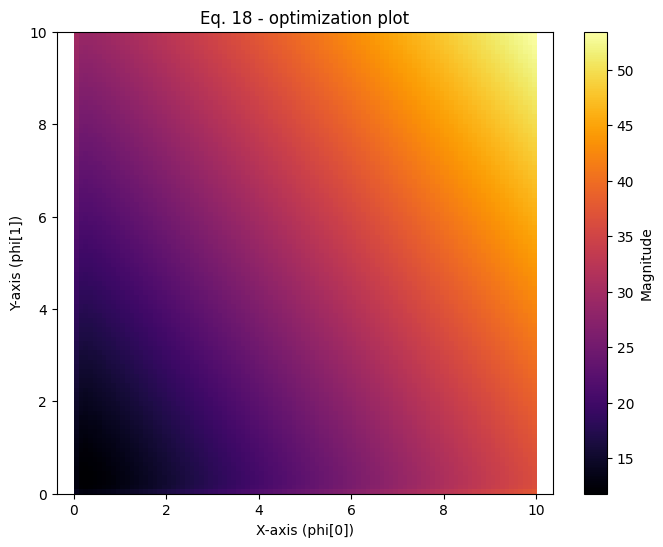

In [14]:
D_KL_search_space = np.linspace(0.01, 10, 100)

# Use parallel processing to speed up the nested loop
results = []
for i in D_KL_search_space:
    for j in D_KL_search_space:
        result = mrblatcomp.D_KL(np.array([10.08, 10.11, i, j]), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=False)
        results.append(result)

# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

gridsize = 100

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(results).reshape(gridsize, gridsize)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, origin='lower', extent=[0, 10, 0, 10], cmap='inferno', aspect='auto')
#min_index = np.argmin(heatmap)
#min_index_2d = np.unravel_index(min_index, heatmap.shape)
#plt.scatter(min_index_2d[1]/gridsize, min_index_2d[0]/gridsize, marker='x', color='red', s=100)
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [15]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)

print(f"Minimum value at index: {min_index_2d}")

np.min(heatmap)

Minimum value at index: (np.int64(2), np.int64(2))


np.float64(11.777371309770665)

In [16]:
gridsize = 100

# Define the range for phi[0] and phi[1]
x_values = np.linspace(0.0001, 50.0001, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(0.0001, 50.0001, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [1],  [1]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (10000, 4, 1)


In [17]:
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(mrblatcomp.D_KL(phis[n][:4].flatten(), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=False))

100%|██████████| 10000/10000 [00:17<00:00, 555.82it/s]


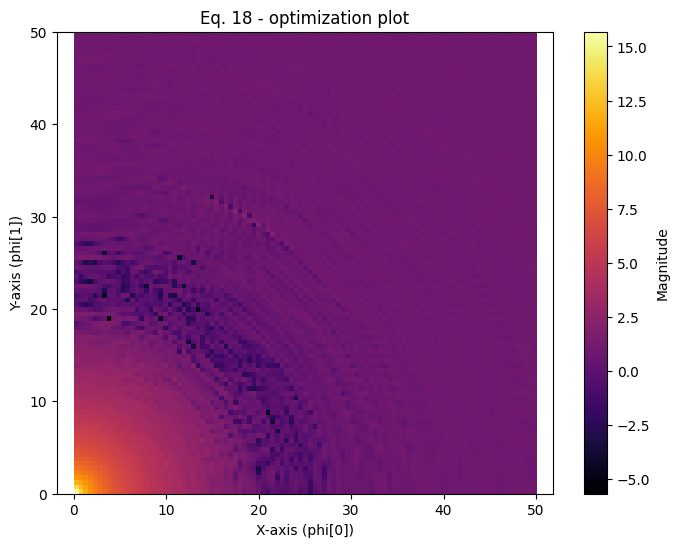

In [18]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.log(np.abs(heatmap[1:,1:])), origin='lower', extent=[0, 50, 0, 50], cmap='inferno')#, aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [19]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")
np.min(heatmap)

Minimum value at index: (np.int64(60), np.int64(37))
x: 18.68696868686869, y: 30.303130303030304


np.float64(-9.696176913126155)

In [15]:
delta_t = 0.1

T = np.array([[1, 0, delta_t, 0],
            [0, 1, 0, delta_t],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

T_inv = np.linalg.inv(T)

mu_a = np.array([[0],
                [0],
                [0],
                [0]])

G = np.diagflat([(delta_t**2)/2,(delta_t**2)/2,delta_t,delta_t])

G_inv = np.linalg.inv(G)

phi = np.array([[10],
                    [10],
                    [0],
                    [0]])

bound = [(-100,100), (0.1,100), (0.00001, 10), (0.00001, 10)]

In [16]:
def broadcast_parameters(n, phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_):
    """
    Each radar computes eps_bar and eps_barbar and broadcasts them.
    """
    # FOR LOOP HERE FOR MULTIPLE RADARS
    sim_data_all_virtual = sim_data[n,:,:,0,:]

    data_fourier = np.fft.fft(sim_data_all_virtual, axis=-1).flatten()

    result = minimize(mrblatcomp.D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), bounds = bound,  args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_, (1,1,1,1), False), method='nelder-mead')
    
    return result.x[np.newaxis].T


def message_passing(N_iter = 80, N = 10):

    eps_bar_list = np.zeros((N, 4, 1))
    eps_barbar_list = np.zeros((N, 4, 4))

    phi_bar_list = np.zeros((N+2, 4, 1))
    phi_barbar_list = np.zeros((N+2, 4, 4))

    phi_bar_list[0] = np.array([[target_ground_truth[0][0]], [target_ground_truth[1][0]], [target_ground_truth[2][0]], [target_ground_truth[3][0]]])
    phi_barbar_list[0] = np.eye((4))*0.01

    # Initialze the Lambda a matrix
    Lambda_a = np.eye((4))*0.01

    fifo = 1

    for n in tqdm(range(N)):
        D_KL_res = broadcast_parameters(n+1, phi_bar_list[n,0,0], phi_bar_list[n,1,0], phi_barbar_list[n,0,0], phi_barbar_list[n,1,1])
        eps_bar = np.vstack((D_KL_res[:2], np.array([[0.], [0.]])))
        
        eps_bar_list[n] = eps_bar
        eps_barbar_list[n] = np.array([[D_KL_res[2][0],0,0,0], [0,D_KL_res[3][0],0,0], [0,0,0,0], [0,0,0,0]])
        
        for _ in range(N_iter):
            for i in range((n+1) - fifo, n+1):
                eps_barbar_inv_extended = np.linalg.pinv(eps_barbar_list[i])
                if (n+1) - i == 1:
                    phi_bar_bar_inv = eps_barbar_inv_extended + G_inv.T@Lambda_a@G
                    phi_bar_bar = np.linalg.pinv(phi_bar_bar_inv)
                    phi_barbar_list[i+1] = phi_bar_bar

                    phi_bar = phi_bar_bar @ (eps_barbar_inv_extended @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i])
                    phi_bar_list[i+1] = phi_bar

                else:
                    phi_bar_bar_inv = eps_barbar_inv_extended + G_inv.T@Lambda_a@G + T.T@G_inv.T@Lambda_a@G_inv@T
                    phi_bar_bar = np.linalg.pinv(phi_bar_bar_inv)
                    phi_barbar_list[i+1] = phi_bar_bar

                    phi_bar = phi_bar_bar @ (eps_barbar_inv_extended @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i] + (T.T@G_inv.T@Lambda_a@G_inv@T)@T_inv@phi_bar_list[i+2])
                    phi_bar_list[i+1] = phi_bar

            #print(phi_bar_list, phi_barbar_list)        
    
            if n >= 1:
                alpha = N+1
                beta = np.zeros((4, 4))
                for i in range((n+1) - fifo, n+1):
                    beta += np.linalg.norm(G_inv@(phi_bar_list[i+1]-T@phi_bar_list[i]))**2  + G_inv@(phi_barbar_list[i+1]+T@phi_barbar_list[i]@T.T)@G_inv.T
                Lambda_a = np.linalg.pinv(beta/alpha)

        if fifo < 80:
            fifo += 1

    return phi_bar_list, phi_barbar_list


In [20]:
%prun message_passing()
# mrblat_data, mrblat_data_phibarbar= message_passing()
#mrblat_data

 10%|█         | 1/10 [00:00<00:06,  1.34it/s]C:\Users\malth\AppData\Local\Temp\ipykernel_26216\3965956235.py:10: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(mrblatcomp.D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), bounds = bound,  args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_, (1,1,1,1), False), method='nelder-mead')
100%|██████████| 10/10 [00:08<00:00,  1.14it/s]

         4991200 function calls in 8.811 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     8032    3.166    0.000    4.050    0.001 fmcwRadar.py:183(generate_S_signal)
     8032    0.958    0.000    0.958    0.000 mrblatFunctions.py:111(partial_sinc)
   205120    0.377    0.000    0.651    0.000 _linalg.py:2566(norm)
     4016    0.374    0.000    7.982    0.002 mrblatFunctions.py:119(D_KL)
    12048    0.354    0.000    0.354    0.000 mrblatFunctions.py:101(sinc)
     4016    0.286    0.000    1.975    0.000 mrblatFunctions.py:44(jacobian_S)
        1    0.190    0.190    8.811    8.811 3965956235.py:15(message_passing)
    16064    0.165    0.000    0.165    0.000 {built-in method scipy.sparse._sparsetools.csc_matvec}
    20080    0.143    0.000    0.222    0.000 _sputils.py:149(get_index_dtype)
   197088    0.131    0.000    0.131    0.000 {method 'dot' of 'numpy.ndarray' objects}
     8032    0.125    0.000    0.125 

In [19]:
# Extract the first two indices from mrbalt_data
x_coords = [data[0, 0] for data in mrblat_data]
y_coords = [data[1, 0] for data in mrblat_data]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords,c=np.linspace(0, 1, len(x_coords)), cmap='viridis', marker='o')
plt.plot(target_ground_truth[0], target_ground_truth[1], c='red')
plt.xlim([-14, 14])
plt.ylim([-5, 50])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('FULL MONTY - MRBLaT')
plt.grid(True)
plt.show()

NameError: name 'mrblat_data' is not defined

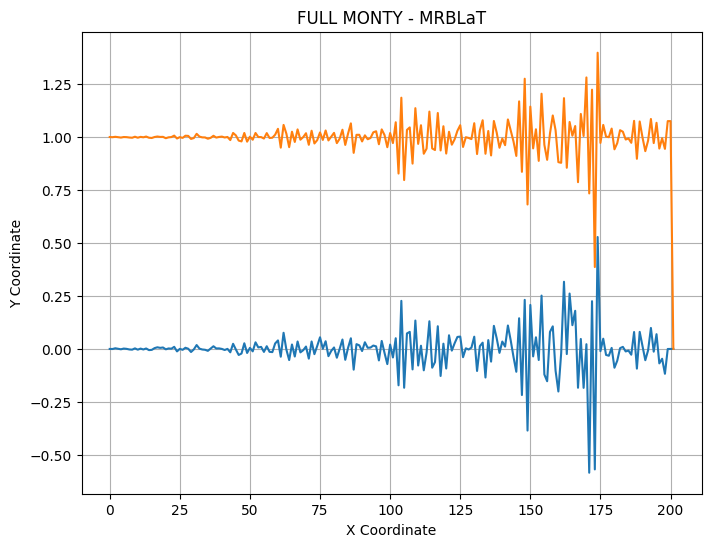

In [45]:
# Extract the first two indices from mrbalt_data
x_coords = [data[2, 0] for data in mrblat_data]
y_coords = [data[3, 0] for data in mrblat_data]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.plot(x_coords)
plt.plot(y_coords)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('FULL MONTY - MRBLaT')
plt.grid(True)
plt.show()

In [18]:
mrblat_data

array([[[ 1.00893354e+01],
        [ 1.01100592e+01],
        [-6.72571388e+01],
        [-6.72571388e+01]],

       [[ 9.27434838e-05],
        [ 1.00092743e-01],
        [-3.32952191e-01],
        [-3.32952191e-01]],

       [[ 9.28716812e-05],
        [ 1.00092872e-01],
        [-3.32952172e-01],
        [-3.32952172e-01]],

       [[ 1.38530375e-04],
        [ 1.00138530e-01],
        [-3.32945323e-01],
        [-3.32945323e-01]],

       [[-1.74176630e-11],
        [ 1.00000000e-01],
        [-2.50000000e-03],
        [-2.50000000e-03]]])

In [ ]:
results = np.zeros((1000, 4))

results[0] = np.array(([10, 10, 1, 1]))  # Initialize results as a list of lists

for n in tqdm(range(999)):

    sim_data_all_virtual = sim_data[n+1,:,:,0,:]
    sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T
    
    result = minimize(mrblatcomp.D_KL, (results[n][0], results[n][1], results[n][2], results[n][3]), bounds = bound,  args=(data_fourier, results[n][0], results[n][1], (1,1,1,1), False), method='nelder-mead')

    results[n+1] = result.x.tolist()  # Insert the result at the correct index

 12%|█▏        | 117/999 [00:32<05:11,  2.83it/s]

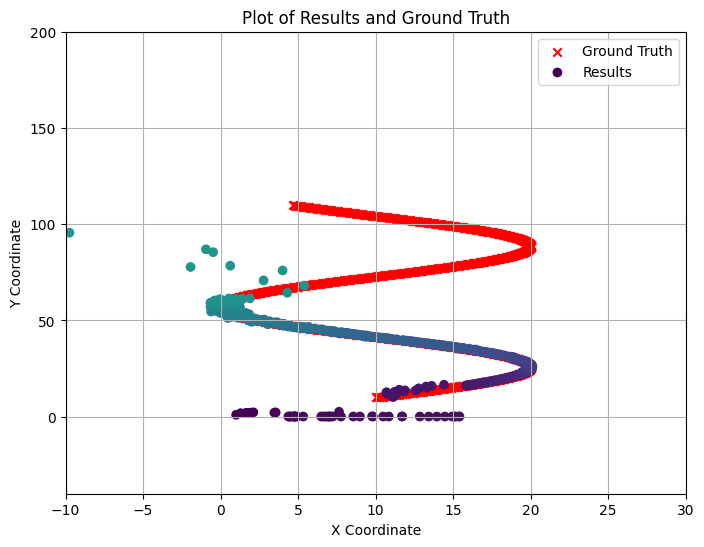

In [ ]:
# Extract the first two indices from results
x_results = [result[0] for result in results]
y_results = [result[1] for result in results]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x', label='Ground Truth')
plt.scatter(x_results, y_results, c=np.linspace(0, 1, len(x_results)), cmap='viridis', marker='o', label='Results')

#plt.scatter(eq18[0][0], eq18[1][0], c='green', marker='x', label='Eq. 18')
plt.xlim([-10, 30])
plt.ylim([-40, 200])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of Results and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()